In [1]:
import math, yaml, sys

import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

from IPython.display import display, HTML

import matplotlib.pyplot as plt
from matplotlib import style

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None  # default='warn'
sns.set_style('ticks')
style.use('ggplot')
%matplotlib inline

## Prep work

In [2]:
train_path = 'train.csv'
test_path = 'test.csv'
schema_path = 'schema.yaml'

#train_path = '/home/benji/workspace-perso/kaggle-house-prices-advanced-regression-techniques/tmp/train.csv'
#test_path = '/home/benji/workspace-perso/kaggle-house-prices-advanced-regression-techniques/tmp/test.csv'
#schema_path = '/home/benji/workspace-perso/kaggle-house-prices-advanced-regression-techniques/tmp/schema.yaml'

In [3]:
# First we need a schema file
schema = yaml.safe_load(open(schema_path, 'r').read())

# convert schema categorical values to string
for c in schema['columns']:
    coldata = schema['columns'][c]
    if 'categories' in coldata:
        coldata['categories'] = [ str(x) for x in coldata['categories'] ]

In [4]:
# Identify which columns are to be loaded as string
dtypes = {}
for c in schema['columns']:
    if schema['columns'][c]['type'] == 'CATEGORICAL':
        dtypes[c] = str

# load data
train = pd.read_csv(train_path, dtype=dtypes)
test = pd.read_csv(test_path, dtype=dtypes)

train0 = train.copy()

In [5]:
target = schema['target']
labels = train[target]
features = set(train.columns) - set([target,schema['id']])
print len(features), 'features'
for f in features:
    print schema['columns'][f]['type'], f
train.drop([target],axis=1,inplace=True)

79 features
NUMERIC 3SsnPorch
CATEGORICAL MasVnrType
CATEGORICAL LotConfig
CATEGORICAL LandSlope
CATEGORICAL GarageQual
CATEGORICAL Exterior1st
CATEGORICAL GarageFinish
NUMERIC 2ndFlrSF
NUMERIC HalfBath
CATEGORICAL OverallQual
CATEGORICAL OverallCond
NUMERIC LotArea
CATEGORICAL Electrical
CATEGORICAL BsmtQual
CATEGORICAL HouseStyle
NUMERIC GrLivArea
NUMERIC YearRemodAdd
NUMERIC MasVnrArea
CATEGORICAL Foundation
NUMERIC 1stFlrSF
NUMERIC BsmtFullBath
CATEGORICAL BsmtCond
CATEGORICAL HeatingQC
NUMERIC LotFrontage
NUMERIC MiscVal
CATEGORICAL CentralAir
CATEGORICAL BsmtExposure
CATEGORICAL Utilities
NUMERIC KitchenAbvGr
NUMERIC WoodDeckSF
CATEGORICAL LotShape
NUMERIC BsmtHalfBath
NUMERIC TotalBsmtSF
CATEGORICAL Condition1
CATEGORICAL Condition2
NUMERIC TotRmsAbvGrd
CATEGORICAL MiscFeature
NUMERIC YrSold
CATEGORICAL PavedDrive
NUMERIC OpenPorchSF
NUMERIC LowQualFinSF
NUMERIC BsmtUnfSF
NUMERIC GarageYrBlt
CATEGORICAL BldgType
NUMERIC FullBath
CATEGORICAL SaleType
CATEGORICAL MSZoning
CATEGORI

In [6]:
all_data = pd.concat((train, test)).reset_index(drop=True)

## Check Sizing

In [7]:
print '# traning observations',train.shape[0]
print '# testing observations',test.shape[0]

print '# traning columns',train.shape[1]
print '# testing columns',test.shape[1]

if not train.shape[1] == train.shape[1]:
    print 'ERROR: inconsistent number of columns between train and test!'

# traning observations 1460
# testing observations 1459
# traning columns 80
# testing columns 80


## Check train+test missing data

Number of features with missing data: 34


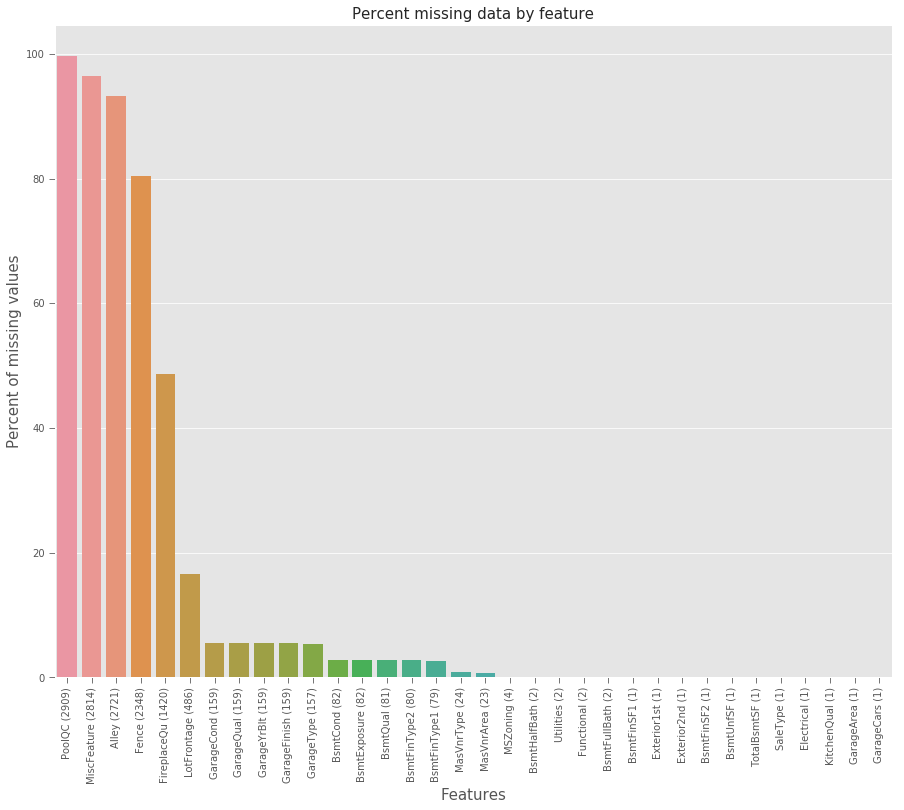

In [8]:
# Check missing data
all_data_na = all_data.isnull().sum(axis=0).sort_values(ascending=False)
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index)

nmissing = all_data_na.shape[0]
print 'Number of features with missing data:',nmissing

if nmissing > 0:
    all_data_na_pct = (all_data_na / all_data.shape[0]) * 100

    annotations = ["{} ({})".format(a, b) for a, b in zip(all_data_na.index, all_data_na.values)]

    f, ax = plt.subplots(figsize=(15, 12))
    sns.barplot(x=annotations, y=all_data_na_pct)

    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)

## Check train+test misspelled categorical data

In [9]:
categorical_features = [c for c in features if schema['columns'][c]['type'] == 'CATEGORICAL' ]
#print 'categorical features:',categorical_features

counter_bad = 0

for c in categorical_features:
    cats = schema['columns'][c]['categories']
    tmp = train[~train[c].isna()]
    tmp = tmp[~tmp[c].isin(cats)]

    if len(tmp) > 0:
        counter_bad += 1
        summary = tmp.groupby(c).size().sort_values(ascending=False)
        display(HTML(summary.to_frame().to_html()))
        print 'Valid categories',cats
        print '----------------------------------------------------------------------------------------------'

print counter_bad,'/',len(categorical_features),'features are misspelled'

,0
BsmtExposure,
No,953


Valid categories ['NA', 'False', 'Mn', 'Av', 'Gd']
----------------------------------------------------------------------------------------------


,0
BldgType,
Duplex,52
Twnhs,43
2fmCon,31


Valid categories ['1Fam', '2FmCon', 'Duplx', 'TwnhsE', 'TwnhsI']
----------------------------------------------------------------------------------------------


,0
Exterior2nd,
CmentBd,60
Wd Shng,38
Brk Cmn,7


Valid categories ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing']
----------------------------------------------------------------------------------------------


,0
Neighborhood,
NAmes,225


Valid categories ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'Greens', 'GrnHill', 'IDOTRR', 'Landmrk', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']
----------------------------------------------------------------------------------------------
4 / 46 features are misspelled


## Check train columns with unique value
This is only relevant if the missing data has already been fixed first.

In [10]:
for c in train.columns:
    if train[c].nunique() <= 1:
        print 'Column',c,'has only one value:',train[c].any()

## Check target variable

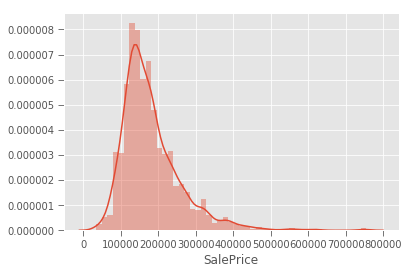

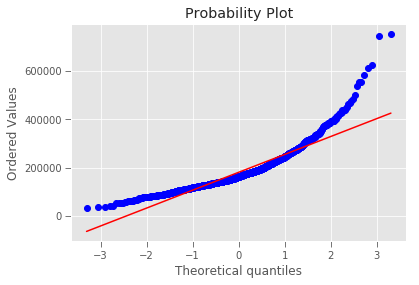

In [11]:
sns.distplot(labels)

fig = plt.figure()
res = stats.probplot(labels, plot=plt)
plt.show()

## Evaluate Skew of NUMERIC features

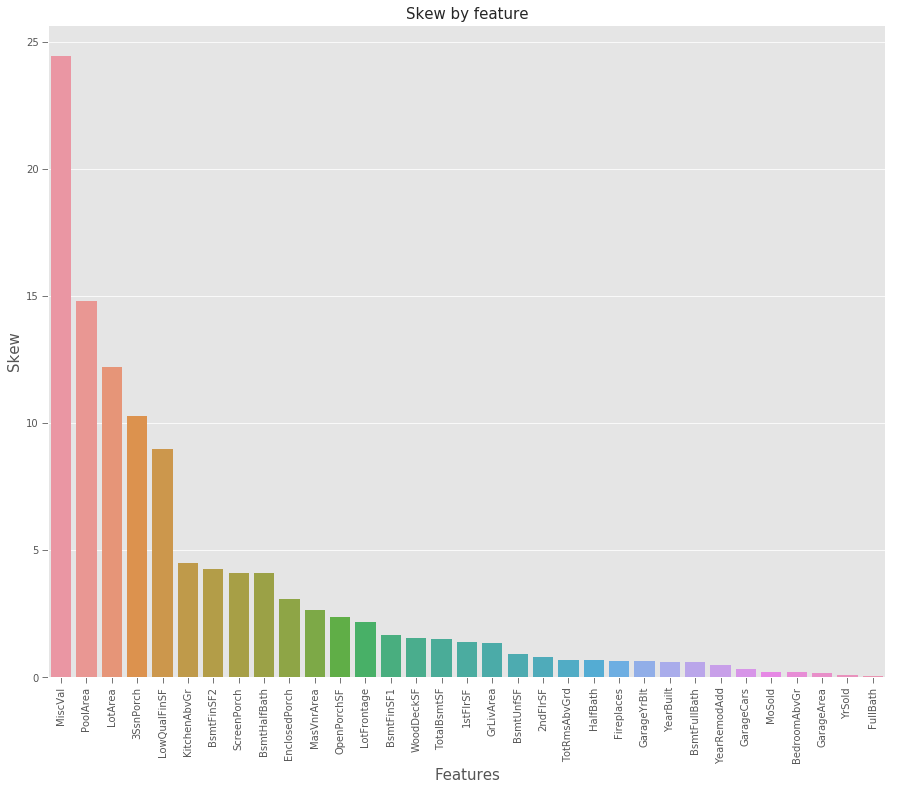

In [12]:
#MIN_UNIQUE_VALUES=2
MIN_UNIQUE_VALUES=3

if True:
    numeric_features = [c for c in features if schema['columns'][c]['type'] == 'NUMERIC' and train[c].nunique() >= MIN_UNIQUE_VALUES ]
    
    skdf = pd.DataFrame(columns=['col','skew'])
    for i, c in enumerate(numeric_features):
        skewness = np.abs(skew(train[c], nan_policy='omit'))
        #print c, skewness
        skdf.loc[i] = [c,skewness]
    
    skdf.sort_values('skew', ascending=False, inplace=True)
    
    f, ax = plt.subplots(figsize=(15, 12))
    sns.barplot(x=skdf['col'], y=skdf['skew'])

    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Skew', fontsize=15)
    plt.title('Skew by feature', fontsize=15)

## Check linearity of train NUMERIC features

1. How does the target variable varry with each numerical feature
2. distribution of feature in training data
3. distribution of feature in testing data

33 numeric features found


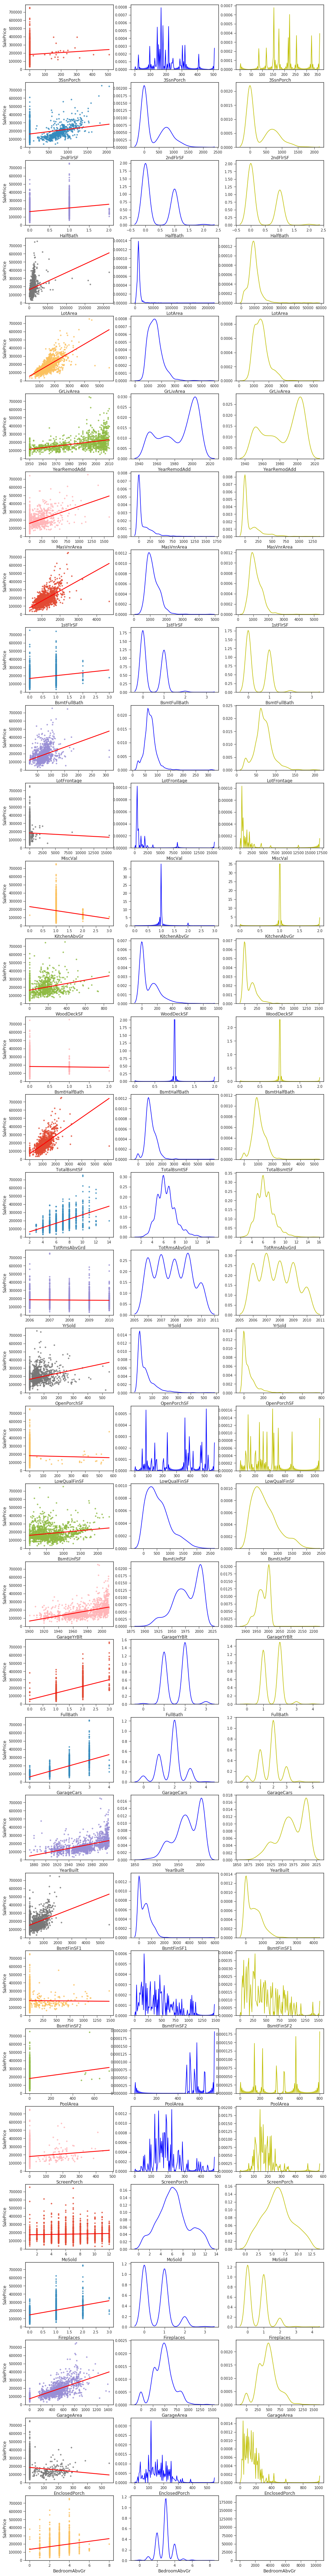

In [13]:
#MIN_UNIQUE_VALUES=2
MIN_UNIQUE_VALUES=3

if True:
    numeric_features = [c for c in features if schema['columns'][c]['type'] == 'NUMERIC' and train[c].nunique() >= MIN_UNIQUE_VALUES ]

    n_num_feat = len(numeric_features)
    print n_num_feat,'numeric features found'

    sns.set_style('ticks')
    fig, ax = plt.subplots(len(numeric_features),3,figsize=(15, n_num_feat*4))
    for i,c in enumerate(numeric_features):
        sns.regplot(x=train[c], y=labels, ax=ax[i,0], scatter_kws={"s": 10},
                    line_kws={'color':'red'}, order=1, ci=None, truncate=True)
        
        sns.distplot(train[c], color='b',ax=ax[i,1], hist=False)
        sns.distplot(test[c], color='y',ax=ax[i,2], hist=False)
        
        #res = stats.probplot(train[c],  plot=ax[i,2])

## Check linearity and population of train CATEGORICAL features

46 categorical features found


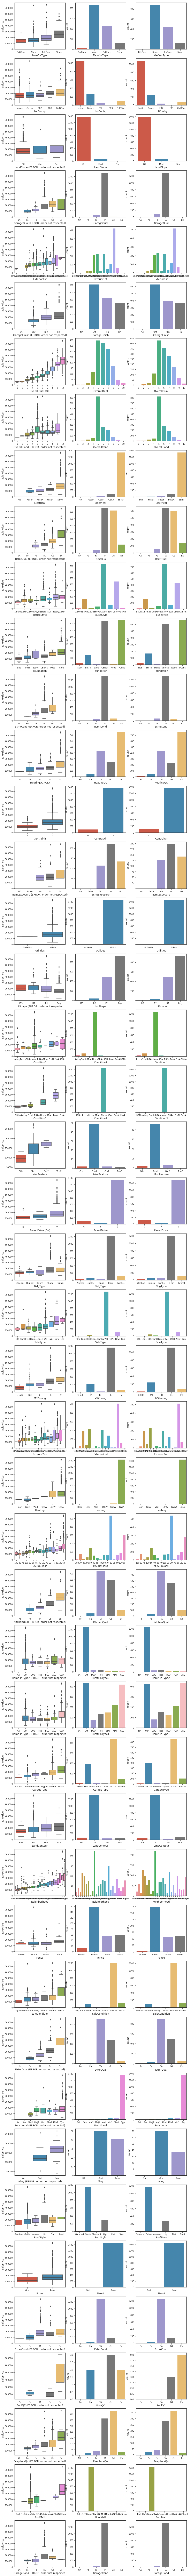

In [14]:
if True:
    categorical_features = [c for c in features if (schema['columns'][c]['type'] == 'CATEGORICAL' or schema['columns'][c]['type'] == 'BINARY') and train[c].nunique() > 1 ]
    #categorical_features=categorical_features[:10]
    n_cat_feat = len(categorical_features)
    print n_cat_feat,'categorical features found'

    sns.set_style('ticks')
    fig, axs = plt.subplots(len(categorical_features), 3, figsize=(15, n_cat_feat*5))

    for idx,c in enumerate(categorical_features):
        coldata = schema['columns'][c]
        categories = coldata['categories']
        meaningful_order = 'meaningful_order' in coldata and coldata['meaningful_order']

        sorted_by_mean = train0[target].groupby(train0[c]).median().sort_values()
        sorted_cats = [ str(x) for x in sorted_by_mean.index ]
        
        display_order = sorted_cats
        boxplot_xname = c

        if meaningful_order:
            # we expect the target to grow with the order
            if sorted_cats == categories:
                boxplot_xname = c+' (OK)'
            else:
                display_order = categories
                boxplot_xname = c+' (ERROR: order not respected)'

        data = pd.concat([labels, train[c]], axis=1)
        sns.boxplot(x=c, y=target, data=data,ax=axs[idx,0],order=display_order)
        axs[idx,0].set_xlabel(boxplot_xname)
        sns.countplot( x=train[c],ax=axs[idx,1], order=display_order)
        sns.countplot( x=test[c],ax=axs[idx,2], order=display_order)